In [1]:
# Визуализации

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["axes.titlesize"] = "large"

In [3]:
# Общеe

import os
import tqdm
import pathlib
import numpy as np
import pandas as pd

In [4]:
# Sklearn
from sklearn.metrics import f1_score, classification_report

# PyTorch etc.
import cv2
import tensorflow as tf
import tensorflow_hub as hub

2023-05-24 07:48:54.273245: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 07:48:54.421929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 07:48:54.424857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 07:48:55.318936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-warning">
Не забудьте заменить <tt>DATA_DIR</tt> на имя локальной директории, в которую сохранили файлы.
</div>

In [6]:
DATA_DIR = pathlib.Path("../data/1/dataset_upload_final/")
CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]
RS = 3984765

# Загрузка данных

Видеоролики из тренировочного набора размещены в директориях, названных по имени класса:

```
dataset/
└── train
     ├── bridge_down
     │   ├── 01531ae3db6e8494.mp4
     │   ...
     │   └── fd39f2310c767b93.mp4
     ├── bridge_up
     │   ├── 009348946266095a.mp4
     │   ...
     │   └── fc176bebf46d3f43.mp4
     ├── no_action
     │   ├── 03b8033d6d547574.mp4
     │   ...
     │   └── fe75e1f7038e4fa8.mp4
     └── train_in_out
          ├── 01f23640259240cf.mp4
          ...
          └── fe8f774e99637f63.mp4
```

In [7]:
train_clips = sum([list(DATA_DIR.joinpath("train", c).glob("*.mp4")) for c in CLASSES], [])
train_clips = pd.DataFrame([clip.parts[-2:] for clip in train_clips], columns=["label", "fname"])

train_clips.head()

,label,fname
0,bridge_down,e5f35a69b5fdde5a.mp4
1,bridge_down,b0b2e92153ee21f3.mp4
2,bridge_down,0a9d37c222ccce4a.mp4
3,bridge_down,0cbedb20b827e285.mp4
4,bridge_down,354914dca502d24e.mp4


In [8]:
train_clips.label.value_counts()

label
bridge_down     306
bridge_up        75
train_in_out     66
no_action        49
Name: count, dtype: int64

Работать с роликами будем напрямую (для простоты настройки окружения, например, не нужно устанавливаться PyAV):

In [9]:
def read_clip(odir: pathlib.Path, fname: str, start: int = 0, transposed: bool = True):
    """Прочесть ролик в массив."""

    cpr = cv2.VideoCapture(odir.joinpath(fname).as_posix())
    has_frame = True
    frames = []

    while has_frame:
        has_frame, frame = cpr.read()
        if has_frame:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if transposed:
                frame = np.moveaxis(frame, -1, 0).copy()

            frames.append(frame)
    cpr.release()
    return np.array(frames)[start:]

In [10]:
sample_clip = train_clips.sample(1, random_state=RS).iloc[0]
clip = read_clip(DATA_DIR.joinpath("train", sample_clip.label), sample_clip.fname, transposed=False)

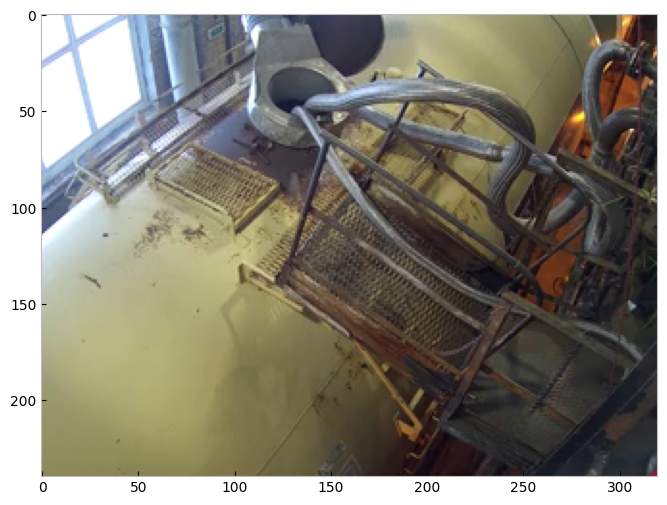

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(clip[15])
plt.grid(False)

In [12]:
clip = read_clip(DATA_DIR.joinpath("train", sample_clip.label), sample_clip.fname, transposed=False)

# Преобразование с помощью претренированной модели

Мы используем очень простой подход:

- с помощью претренированной модели извлечём признаки для каждого кадра,
- посчитаем средняя значение для всего ролика,
- натренируем простую модель на полученных признаках.

Для извлечения признаков используем какую-либо из моделей, доступных в TensorFlow Hub. Обращаем внимание, что эта модель не даёт каких-то существенных значений F1, заведомо не обобщается и приведена для примера.

Это рекомендуемый способ (вместе с `launch.json`, см. ниже): так вы избежите необходимости грузить веса вручную. Загрузить веса претренированных моделей при работе контейнера не получится, поскольку он не будет иметь доступа к сети.

Для ускорения будет уменьшать изображения до `96 x 96`:

In [13]:
fts_extract = tf.keras.Sequential([
    tf.keras.layers.Resizing(96, 96, interpolation="bilinear"),
    tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5", trainable=False)
])
fts_extract.build([None, 240, 320, 3])

Вариант для PyTorch будет выглядеть иначе (на примере [ShuffleNet](https://pytorch.org/vision/stable/models/shufflenetv2.html)):

```python
weights = models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1
model = models.shufflenet_v2_x0_5(weights=weights, progress=True)

summary(model,
        input_size=(32, 3, 224, 224),
        col_width=25,
        col_names=["input_size", "output_size", "trainable"])
```

Для этого необходимо добавить импорты:

```python
import torch
import torchvision
from torchvision import models, transforms
from torchinfo import summary
```

Кроме того, к изображениям необходимо применить преобразование иначе:
```python
transform = weights.transforms()
clip_t = torch.Tensor(clip[15] / 255)
transform(clip_t)
```

Посмотрим на пример признаков:

In [14]:
features_f = fts_extract(clip).numpy()

2023-05-24 07:51:51.668418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 234086400 exceeds 10% of free system memory.
2023-05-24 07:51:52.024270: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 224722944 exceeds 10% of free system memory.


Получаем `1280` признаков (как и ожидается от этой модели):

In [15]:
features_f.shape

(254, 1280)

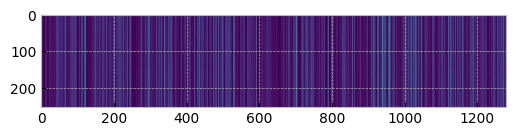

In [16]:
plt.imshow(features_f)

# Вычисляем признаки

У нас всего 496 роликов, поэтому 1280 признаков нам не нужны (и избыточны). Однако и нормально провести dimensionality reduction при таком количестве признаков тоже непросто. Поэтому сделаем random projection:

In [17]:
train_clips

,label,fname
0,bridge_down,e5f35a69b5fdde5a.mp4
1,bridge_down,b0b2e92153ee21f3.mp4
2,bridge_down,0a9d37c222ccce4a.mp4
3,bridge_down,0cbedb20b827e285.mp4
4,bridge_down,354914dca502d24e.mp4
...,...,...
491,train_in_out,15a80e7c7a533d3d.mp4
492,train_in_out,7b11b87dd010c638.mp4
493,train_in_out,d2987e35db4635c9.mp4
494,train_in_out,2ce08918cccbf9d0.mp4


In [18]:
from sklearn.random_projection import GaussianRandomProjection

In [19]:
projector = GaussianRandomProjection(n_components=50, random_state=RS)
projector.fit(np.random.rand(10, 1280))

GaussianRandomProjection(n_components=50, random_state=3984765)

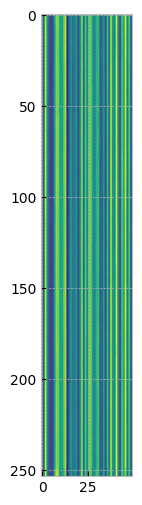

In [20]:
plt.imshow(projector.transform(features_f))

In [21]:
BS = 32

In [23]:
features = []

for ci, row in tqdm.tqdm(train_clips.iterrows(), total=train_clips.shape[0]):
    clip = read_clip(DATA_DIR.joinpath("train", row.label), row.fname, transposed=False)
    outputs = fts_extract(clip)
    features.append(projector.transform(outputs.numpy()).mean(axis=0))

  0%|          | 0/496 [00:00<?, ?it/s]2023-05-24 07:53:24.393248: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 228556800 exceeds 10% of free system memory.
2023-05-24 07:53:24.506332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 219414528 exceeds 10% of free system memory.
100%|██████████| 496/496 [04:56<00:00,  1.67it/s]


In [24]:
features = np.vstack(features)

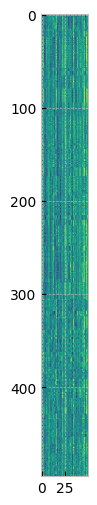

In [25]:
plt.imshow(features)

# Модель

Попробуем натренировать простую модель на этих признаках.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [28]:
df = pd.DataFrame(features, index=train_clips.index, columns=[f"fts{i}" for i in range(features.shape[1])])

In [29]:
df = train_clips.join(df)

In [30]:
df_train, df_val = train_test_split(df, train_size=0.75, stratify=df.label)

In [31]:
df.filter(like="fts")

,fts0,fts1,fts2,fts3,fts4,fts5,fts6,fts7,fts8,fts9,...,fts40,fts41,fts42,fts43,fts44,fts45,fts46,fts47,fts48,fts49
0,6.569531,-7.721365,7.437668,-0.016587,-3.083952,-1.973350,-6.009511,-3.963573,0.103193,-0.257392,...,1.023474,2.101838,-5.771504,3.034152,10.176340,2.250651,3.530674,-1.769796,5.097129,0.661868
1,6.283924,-10.534566,6.259919,-2.317836,-9.925704,1.218672,-5.202241,1.864305,1.214721,2.755202,...,0.084065,1.079016,-3.528147,0.623369,3.531142,0.432082,4.715826,-14.650573,1.007025,-0.072882
2,6.114090,-9.105900,6.568962,-2.076069,-10.003262,1.002161,-6.096346,2.098007,1.445889,2.802755,...,-0.646114,2.077142,-3.826670,0.458284,3.661804,0.461943,3.205912,-14.712834,0.953382,-0.585271
3,2.890829,-9.081045,0.619089,1.919957,-6.778055,1.263605,-8.180493,3.025767,0.347065,1.553463,...,-1.464683,1.734034,-0.782479,1.802045,5.187633,2.264639,6.902780,-11.807053,-1.546698,3.755109
4,6.069574,-8.960627,6.923382,0.640625,-6.520155,-1.488293,-2.228816,2.840800,-2.258444,4.385549,...,1.454612,-0.751942,-2.520609,0.215632,6.290827,-1.581137,3.549566,-5.329663,1.909135,2.589628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,-2.637232,-4.088146,5.116719,-1.845585,-2.646413,1.156945,0.875141,2.804753,6.853201,-1.861731,...,-6.604254,6.688292,-0.755443,-1.820704,6.673156,2.860103,-0.651445,-5.604997,5.850603,-1.029724
492,-2.222169,-5.245037,5.627678,-1.366383,-2.638334,0.106245,0.995889,2.229580,7.712530,-1.585756,...,-6.434877,6.682803,-2.974297,-3.297069,5.634849,1.951620,1.227801,-6.016628,6.072275,-1.825412
493,-0.087214,-1.916835,3.043614,-0.290930,-4.711637,5.506099,1.433293,2.299524,7.851522,-6.044421,...,-10.132809,7.252396,-0.277760,-1.391570,5.060113,3.034022,2.380779,-9.139935,6.788570,0.380474
494,2.201075,-6.538152,6.416442,0.445302,-8.724636,-0.796180,-6.009478,-2.140705,6.248882,-0.671616,...,7.055158,2.577782,-1.668051,-2.152619,0.239333,3.580415,6.187911,1.201115,9.030312,2.254681


In [35]:
classifier = LogisticRegression(C=0.1, class_weight="balanced")
classifier.fit(df_train.filter(like="fts"), df_train.label)

LogisticRegression(C=0.1, class_weight='balanced')

In [36]:
train_preds = classifier.predict(df_train.filter(like="fts"))
val_preds = classifier.predict(df_val.filter(like="fts"))

In [37]:
print("TRAIN:")
print(classification_report(df_train.label, train_preds))

print("VAL:")
print(classification_report(df_val.label, val_preds))

TRAIN:
              precision    recall  f1-score   support

 bridge_down       1.00      0.94      0.97       230
   bridge_up       0.84      0.93      0.88        56
   no_action       0.97      1.00      0.99        37
train_in_out       0.84      0.96      0.90        49

    accuracy                           0.95       372
   macro avg       0.91      0.96      0.93       372
weighted avg       0.95      0.95      0.95       372

VAL:
              precision    recall  f1-score   support

 bridge_down       0.93      0.86      0.89        76
   bridge_up       0.62      0.53      0.57        19
   no_action       0.67      0.83      0.74        12
train_in_out       0.48      0.65      0.55        17

    accuracy                           0.77       124
   macro avg       0.67      0.72      0.69       124
weighted avg       0.79      0.77      0.78       124



In [38]:
from joblib import dump, load
dump(classifier, 'classifier-v1.joblib')
dump(projector, 'projector-v1.joblib')

['projector-v1.joblib']

Подготовим сабмит:

In [2]:
%%writefile predict.py

import pathlib
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from joblib import load

PROJECTOR_FILE = pathlib.Path(__file__).parent.joinpath("projector-v1.joblib")
CLASSIFIER_FILE = pathlib.Path(__file__).parent.joinpath("classifier-v1.joblib")


def construct_model():
    fts_extract = tf.keras.Sequential([
        tf.keras.layers.Resizing(96, 96, interpolation="bilinear"),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5", trainable=False)
    ])
    fts_extract.build([None, 240, 320, 3])
    return fts_extract


model = construct_model()
projector = load(PROJECTOR_FILE)
classifier = load(CLASSIFIER_FILE)


def predict(clip: np.ndarray):
    """Вычислить класс для этого клипа. Эта функция должна возвращать *имя* класса."""

    features = projector.transform(model(clip).numpy()).mean(axis=0, keepdims=True)
    return classifier.predict(features)[0]

Overwriting predict.py


Файл `launch.json` позволяет загрузить веса при сборке контейнера:

In [3]:
%%writefile launch.json
{
    "torch": ["shufflenet_v2_x0_5"],
    "tfhub": ["https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/5"],
    "transposed": false
}

Overwriting launch.json


В поле `torch` должен быть список (не более 3-х моделей) моделей из `torchvision.models.list_models()`. Для примера показана загрузка модели ShuffleNet.

В поле `tfhub` - список ссылок (не более 3-х) на любые валидные модели из TensorFlow Hub. Другие способы предзагрузки недоступны, поэтому веса придётся грузить вручную.

Поле `transposed` указывает, нужно ли подавать ролик в формате `H x W x C` (`false`, дефолтный вариант) или `C x H x W` (`true`).

# Дополнение

Аналогичную модель (в данном случае: c классификаторорм) можно получить иначе, с помощью Keras Applications:

In [39]:
def construct_model():
    feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                                          weights='imagenet')
    inputs = tf.keras.layers.Input((240, 320, 3))
    
    resized = tf.keras.layers.Resizing(96, 96, interpolation="bilinear")(inputs)
    rescaled = tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)(resized)
    outputs = feature_extractor(rescaled)

    return tf.keras.Model(inputs, outputs)

In [40]:
model = construct_model()

In [41]:
features_f = model(clip).numpy()

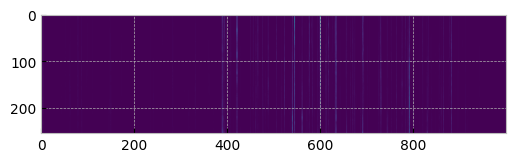

In [42]:
plt.imshow(features_f)

При этом веса придётся добавлять в сабмит и загружать их в модель из файла, посколько для Keras такого е простого способа предварительного скачивания весов.